In [1]:
import numpy as np
# import matplotlib.pyplot as plt
from regressio.datagen import generate_random_walk
from regressio.models import polynomial_regression

np.random.seed(5)
x,y = generate_random_walk(100, 0.1, plot=False)

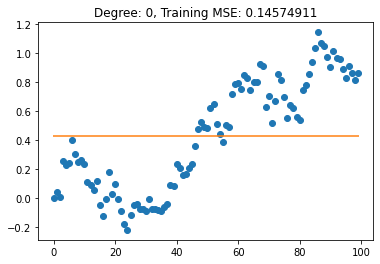

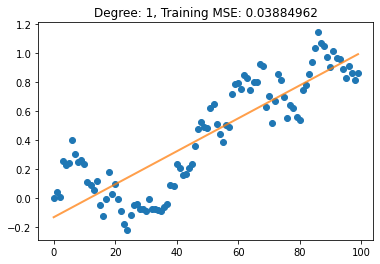

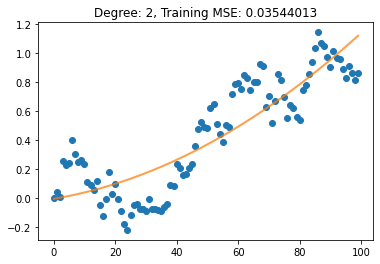

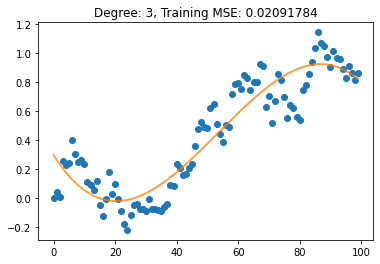

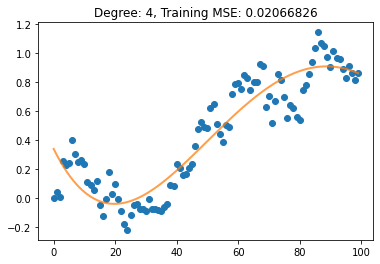

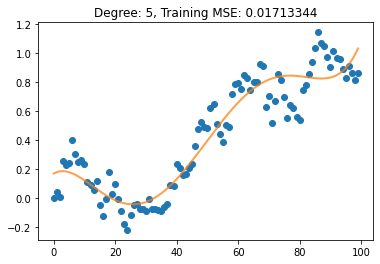

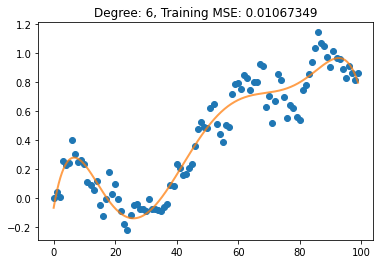

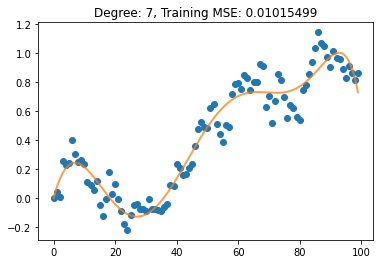

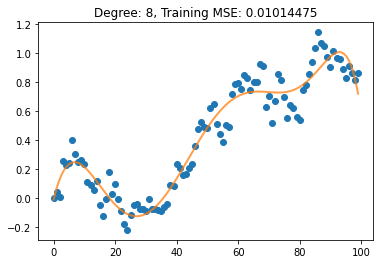

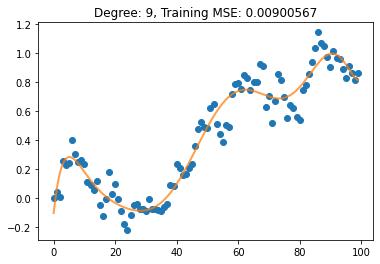

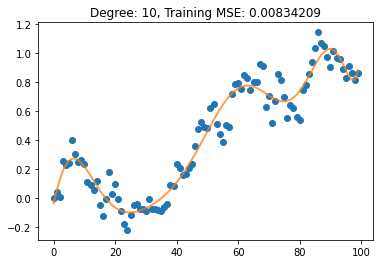

In [2]:
for i in range(11):
    model = polynomial_regression(n=i)
    model.fit(x, y)